In [ ]:
import pytz
import pandas
from datetime import datetime

import gtfs_kit as gk
import matplotlib.pyplot as plt

In [2]:
vehicle_positions = pandas.read_parquet("../downloads/vehicle_positions.parquet")
vehicle_positions = vehicle_positions.tz_localize("UTC")

In [3]:
feed = gk.read_feed("../downloads/schedule_updates/2024-03-20T06_34_14.zip", dist_units="km")

## Routes

### Number of planned routes

In [4]:
routes = feed.get_routes()
route_ids = routes["route_id"].unique()

In [5]:
def get_monitored_route_ids(vehicle_positions: pandas.DataFrame):
    return vehicle_positions["vehicle.trip.route_id"].unique()

In [6]:
monitored_route_ids = get_monitored_route_ids(vehicle_positions)
unimonitored_route_ids = set(route_ids) - set(monitored_route_ids)

### % of monitored routes

In [7]:
NUM_METRO_LINES = 4

round(len(monitored_route_ids) / (len(route_ids) - NUM_METRO_LINES) * 100, 1)

95.2

### Unmonitored routes

In [8]:
routes[routes["route_id"].isin(unimonitored_route_ids)][["route_short_name", "route_long_name", "route_url"]]

,route_short_name,route_long_name,route_url
11,551,<NA>,https://muoversiaroma.it/it/linea?numero=551
28,500,<NA>,https://muoversiaroma.it/it/linea?numero=500
55,246,<NA>,https://muoversiaroma.it/it/linea?numero=246
58,021,<NA>,https://muoversiaroma.it/it/linea?numero=021
236,043,<NA>,https://muoversiaroma.it/it/linea?numero=043
242,113,<NA>,https://muoversiaroma.it/it/linea?numero=113
244,246P,<NA>,https://muoversiaroma.it/it/linea?numero=246P
246,351,<NA>,https://muoversiaroma.it/it/linea?numero=351
254,319,<NA>,https://muoversiaroma.it/it/linea?numero=319
269,718,<NA>,https://muoversiaroma.it/it/linea?numero=718


## Route Analysis

In [4]:
ROUTE = "87"
DATE = datetime(2024, 3, 20, 4, tzinfo=pytz.timezone("Europe/Rome"))

In [ ]:
vehicle_positions = vehicle_positions[
    vehicle_positions.index.to_series().dt.date == DATE.date()
]  # TODO fondalmente... c'è un bordello con le date

In [ ]:
# route_timetable = feed.build_route_timetable(ROUTE, [DATE.strftime("%Y%m%d")])

In [ ]:
# def get_route_vehicle_positions(vehicle_positions: pandas.DataFrame, route: str, date: datetime):
#     route_vehicle_positions = vehicle_positions[vehicle_positions["vehicle.trip.route_id"] == route].copy()
#     # route_vehicle_positions["vehicle.trip.trip_id"] = route_vehicle_positions["vehicle.trip.trip_id"].str.replace("0#", "1#")
#     route_vehicle_positions.reset_index(inplace=True)
#     route_vehicle_positions = route_vehicle_positions[route_vehicle_positions["vehicle.timestamp"] >= date]
#     return route_vehicle_positions.sort_values("vehicle.timestamp")

In [ ]:
# route_vehicle_positions = get_route_vehicle_positions(vehicle_positions, route=ROUTE, date=DATE)

In [6]:
def compute_speed_per_route_and_trip(
    vehicle_positions: pandas.DataFrame,
    commercial: bool,
    min_cutoff: float = 5.0,
    max_cutoff: float = 25.0,
) -> pandas.DataFrame:
    relevant_cols = [
        "vehicle.trip.route_id",
        "vehicle.trip.trip_id",
        "vehicle.timestamp",
        "vehicle.position.odometer",
        "vehicle.current_status",
    ]
    relevant_view = vehicle_positions.reset_index()[relevant_cols]  # TODO keep timestamp as index?

    odometer_and_timestamp_minmax = (
        relevant_view[relevant_view["vehicle.current_status"] != (-1 if commercial else 1)]
        .groupby(["vehicle.trip.route_id", "vehicle.trip.trip_id"], observed=False)
        .agg({"vehicle.timestamp": ["min", "max"], "vehicle.position.odometer": ["min", "max"]})
    )

    speed = (
        (
            (
                odometer_and_timestamp_minmax["vehicle.position.odometer"]["max"]
                - odometer_and_timestamp_minmax["vehicle.position.odometer"]["min"]
            )
            / 1000  # km
        )
        / (
            (
                odometer_and_timestamp_minmax["vehicle.timestamp"]["max"]
                - odometer_and_timestamp_minmax["vehicle.timestamp"]["min"]
            ).dt.seconds
            / 3600  # hours
        )
    ).rename(f"vehicle.{'commercial' if commercial else 'travel'}_speed_kmh")

    return speed[(min_cutoff < speed) & (speed < max_cutoff)]

In [7]:
travel_speed = compute_speed_per_route_and_trip(vehicle_positions, commercial=False)

In [85]:
commercial_speed = compute_speed_per_route_and_trip(vehicle_positions, commercial=True, min_cutoff=1., max_cutoff=100.)

<Axes: >

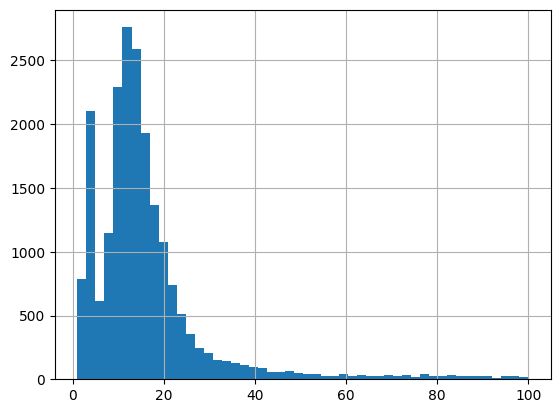

In [86]:
commercial_speed.hist(bins=50)

In [87]:
travel_speed.describe()

count    13994.000000
mean        15.404728
std          4.995537
min          5.000294
25%         12.004595
50%         15.251066
75%         19.188664
max         24.998333
Name: vehicle.travel_speed_kmh, dtype: float64

In [88]:
commercial_speed.groupby(level="vehicle.trip.route_id", observed=False).mean().sort_values(ascending=False)

vehicle.trip.route_id
089    95.462795
020    88.560000
303    87.532409
713    83.925784
087    83.661033
         ...    
C3           NaN
C4           NaN
C5           NaN
C7           NaN
C9           NaN
Name: vehicle.commercial_speed_kmh, Length: 400, dtype: float64

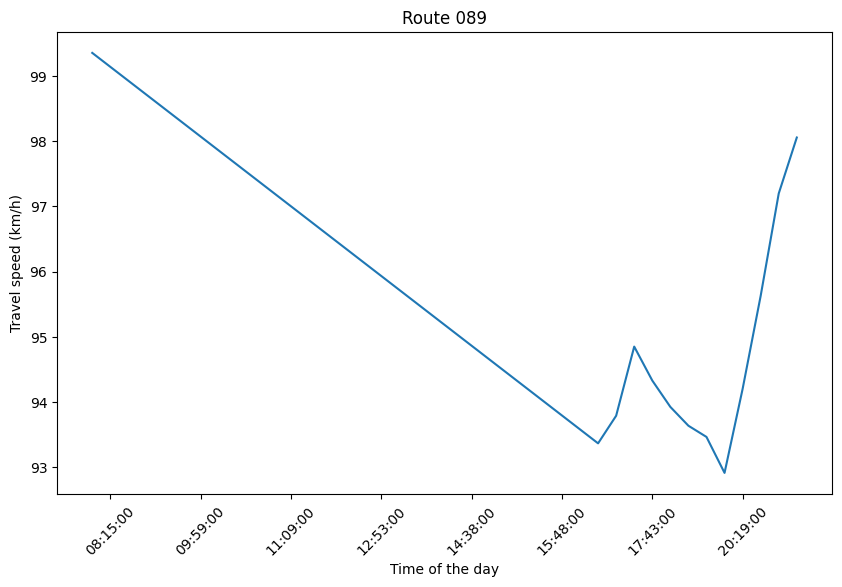

In [89]:
ROUTE_ID = "089"

(
    vehicle_positions[["vehicle.trip.route_id", "vehicle.trip.trip_id", "vehicle.trip.start_time"]]
    .drop_duplicates()
    .set_index(["vehicle.trip.route_id", "vehicle.trip.trip_id"])
    .join(commercial_speed)
    .loc[ROUTE_ID]
    .set_index("vehicle.trip.start_time")
    .sort_index()  # TODO remove when it's fucking timestamp
    .interpolate()
    .rolling(5)
    .mean()
    .plot(
        rot=45,
        title=f"Route {ROUTE_ID}",
        ylabel="Travel speed (km/h)",
        xlabel="Time of the day",
        legend=False,
        figsize=(10,6)
    )
)

plt.show()

## Failed Trips

In [12]:
route_planned_trips = route_timetable["trip_id"].unique()
route_actual_trips = route_vehicle_positions["vehicle.trip.trip_id"].unique()
route_failed_trips = set(route_planned_trips) - set(route_actual_trips)
len(route_planned_trips), len(route_failed_trips)

(208, 35)

In [13]:
route_timetable[(route_timetable["trip_id"].isin(route_failed_trips)) & (route_timetable["stop_sequence"] == 1)][
    ["trip_id", "trip_headsign", "departure_time", "date"]
]

,trip_id,trip_headsign,departure_time,date
32,0#4657-3,MUSE,05:28:00,20240320
185,0#4657-4,ZAMA,05:50:00,20240320
425,0#4657-5,MUSE,06:31:00,20240320
621,0#4660-4,MUSE,07:02:00,20240320
740,0#4657-6,ZAMA,07:22:00,20240320
936,0#4650-3,MUSE,07:46:00,20240320
981,0#4660-5,ZAMA,07:52:00,20240320
1161,0#4650-4,ZAMA,08:19:00,20240320
1192,0#4657-7,MUSE,08:27:00,20240320
1372,0#4660-6,MUSE,08:56:00,20240320


In [23]:
trip_positions = route_vehicle_positions[route_vehicle_positions["vehicle.trip.trip_id"] == "0#4648-3"][
    ["vehicle.position.latitude", "vehicle.position.longitude"]
].values